## Load libraries

In [1]:
import random
from collections import Counter
from datetime import timedelta
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

In [2]:
sns.set_style("darkgrid")
warnings.simplefilter("ignore")

## Load data

Since it is a pretty big dataset, we will load it in chunks

In [3]:
chunksize = 20_000

train_data = pd.read_json("../input/otto-recommender-system/train.jsonl", lines=True, chunksize=chunksize)
# test_data = pd.read_json("../input/otto-recommender-system/test.jsonl", lines=True, chunksize=chunksize)
# sample_submission = pd.read_csv("../input/otto-recommender-system/sample_submission.csv", chunksize=chunksize)

 Number of sessions in train and test

In [4]:
with open('../input/otto-recommender-system/train.jsonl', 'r') as f:
    print(f"Train: {len(f.readlines()):,} lines")
with open('../input/otto-recommender-system/test.jsonl', 'r') as f:
    print(f"Test {len(f.readlines()):,} lines")

Train: 12,899,779 lines
Test 1,671,803 lines


As we can see from above that dataset is realy big. So we will load the first chunk of data to examine structure of the datset

In [5]:
train_chunk_data = train_data.__next__()
train_chunk_data

,session,events
0,0,"[{'aid': 1517085, 'ts': 1659304800025, 'type':..."
1,1,"[{'aid': 424964, 'ts': 1659304800025, 'type': ..."
2,2,"[{'aid': 763743, 'ts': 1659304800038, 'type': ..."
3,3,"[{'aid': 1425967, 'ts': 1659304800095, 'type':..."
4,4,"[{'aid': 613619, 'ts': 1659304800119, 'type': ..."
...,...,...
19995,19995,"[{'aid': 1481519, 'ts': 1659305842045, 'type':..."
19996,19996,"[{'aid': 1109584, 'ts': 1659305842183, 'type':..."
19997,19997,"[{'aid': 1647277, 'ts': 1659305842315, 'type':..."
19998,19998,"[{'aid': 753948, 'ts': 1659305842328, 'type': ..."


In [6]:
train_chunk_data.iloc[112]["events"]

[{'aid': 1556453, 'ts': 1659304801664, 'type': 'clicks'},
 {'aid': 1556453, 'ts': 1659304804055, 'type': 'carts'},
 {'aid': 1572879, 'ts': 1659304918252, 'type': 'clicks'},
 {'aid': 1374838, 'ts': 1659304929527, 'type': 'clicks'},
 {'aid': 1374838, 'ts': 1659304937453, 'type': 'clicks'},
 {'aid': 199865, 'ts': 1659304969527, 'type': 'clicks'},
 {'aid': 1567940, 'ts': 1659341229359, 'type': 'clicks'},
 {'aid': 51798, 'ts': 1659341236788, 'type': 'clicks'},
 {'aid': 693625, 'ts': 1659465963886, 'type': 'clicks'},
 {'aid': 693625, 'ts': 1659466437047, 'type': 'clicks'},
 {'aid': 1828810, 'ts': 1659466493303, 'type': 'clicks'},
 {'aid': 1014210, 'ts': 1659466552636, 'type': 'clicks'},
 {'aid': 1001000, 'ts': 1659466605871, 'type': 'clicks'},
 {'aid': 1528969, 'ts': 1659466620637, 'type': 'clicks'},
 {'aid': 500582, 'ts': 1659466664246, 'type': 'clicks'},
 {'aid': 28010, 'ts': 1659466683724, 'type': 'clicks'},
 {'aid': 1017261, 'ts': 1659466861733, 'type': 'clicks'},
 {'aid': 1545215, 'ts':

As we see, data has the nest structure:
- session - the unique id of session
- events - ordered events, that happened in this session. Each event consists of:
    - aid - the article id (product code) of the associated event
    - ts - the Unix timestamp of the event (in microseconds)
    - type - the event type ("clicks", "carts", "orders"). Whether a product was clicked, added to the user's cart, or ordered during the session

## Extracting data for use

Because full dataset is big, let's get a few chunks to perform analysis on

In [7]:
indices = [i for i in range(100)]
random.shuffle(indices)
indices = indices[:3]
print("Data chosen from chunks: ",indices)

chunks_train = []
for idx, chunk in enumerate(train_data):
    if idx in indices:
        chunks_train.append(chunk)
    if idx > max(indices):
        break

chunks_train = pd.concat(chunks_train)
chunks_train

Data chosen from chunks:  [29, 18, 55]


,session,events
380000,380000,"[{'aid': 238602, 'ts': 1659346900504, 'type': ..."
380001,380001,"[{'aid': 406002, 'ts': 1659346900588, 'type': ..."
380002,380002,"[{'aid': 854838, 'ts': 1659346900739, 'type': ..."
380003,380003,"[{'aid': 1420240, 'ts': 1659346900922, 'type':..."
380004,380004,"[{'aid': 374412, 'ts': 1659346900967, 'type': ..."
...,...,...
1139995,1139995,"[{'aid': 706057, 'ts': 1659384526449, 'type': ..."
1139996,1139996,"[{'aid': 1330393, 'ts': 1659384526451, 'type':..."
1139997,1139997,"[{'aid': 1427818, 'ts': 1659384526569, 'type':..."
1139998,1139998,"[{'aid': 1602377, 'ts': 1659384526570, 'type':..."


## transform dataset to csv format

In [8]:
events_data = {
    "session": [],
    "aid": [],
    "ts": [],
    "type": [],
    "typeN":[],
}
def _conType_to_rating(eventType):
    if(eventType=="clicks"):
        return 3
    else:
        if(eventType=="carts"):
            return 4
        else:
            if(eventType=="orders"):
                return 5
    
for _, row in chunks_train.iterrows():
    for event in row["events"]:
        events_data["session"].append(row["session"])
        events_data["aid"].append(event["aid"])
        events_data["ts"].append(event["ts"])
        events_data["type"].append(event["type"])
        events_data["typeN"].append(_conType_to_rating(event["type"]))

train_Pdata = pd.DataFrame(events_data)
train_Pdata
train_Pdata.describe()

,session,aid,ts,typeN
count,2.122467e+06,2.122467e+06,2.122467e+06,2.122467e+06
mean,6.753879e+05,9.296989e+05,1.660291e+12,3.120124e+00
std,3.013389e+05,5.370315e+05,7.563673e+08,3.874839e-01
min,3.800000e+05,0.000000e+00,1.659347e+12,3.000000e+00
25%,3.932030e+05,4.680230e+05,1.659551e+12,3.000000e+00
50%,6.073080e+05,9.309830e+05,1.660194e+12,3.000000e+00
75%,1.122419e+06,1.395485e+06,1.660932e+12,3.000000e+00
max,1.139999e+06,1.855601e+06,1.661724e+12,5.000000e+00


In [9]:
train_Pdata

,session,aid,ts,type,typeN
0,380000,238602,1659346900504,clicks,3
1,380000,699980,1659733000981,clicks,3
2,380000,799759,1659862158512,clicks,3
3,380000,799759,1659862180203,clicks,3
4,380000,799759,1659862199728,clicks,3
...,...,...,...,...,...
2122462,1139998,1602377,1659384569689,carts,4
2122463,1139998,804966,1660071499633,clicks,3
2122464,1139999,1826422,1659384526613,clicks,3
2122465,1139999,1371870,1661076587324,clicks,3


##  EDA Analysis

1) calculate number of sessions and events in this dataset

In [10]:
n_sessions = train_Pdata["session"].nunique()
n_events = train_Pdata.shape[0]

print("Number of sessions:" ,{n_sessions})
print("Number of events: ",{n_events})
print("Mean number of events in session: ",{n_events/n_sessions})

Number of sessions: {60000}
Number of events:  {2122467}
Mean number of events in session:  {35.37445}


2)relation of numbers of events and sessions

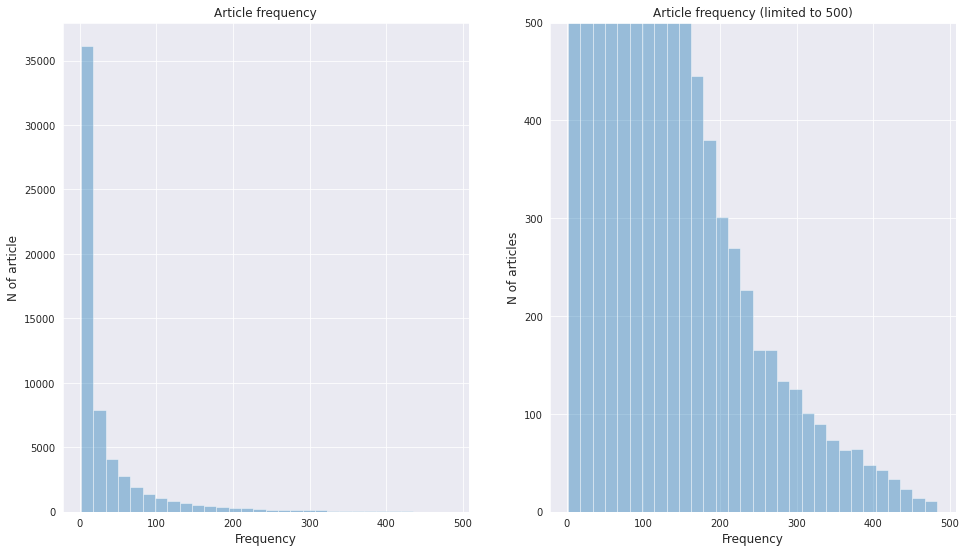

In [11]:
events_in_session = train_Pdata.groupby(['session'])['aid'].count().sort_values(ascending=False)

fig, ax = plt.subplots(ncols=2, figsize=(16, 9))
sns.distplot(x=events_in_session.values, ax=ax[0], bins=30, kde=False)
ax[0].set_title('Article frequency', fontsize=12)
ax[0].set_ylabel('N of article', fontsize=12)
ax[0].set_xlabel('Frequency', fontsize=12)

sns.distplot(x=events_in_session.values, ax=ax[1], bins=30, kde=False)
ax[1].set_title('Article frequency (limited to 500)', fontsize=12)
ax[1].set_ylabel('N of articles', fontsize=12)
ax[1].set_xlabel('Frequency', fontsize=12)
ax[1].set_ylim(0, 500)

plt.show()

It seems that the majority of the articles have been accessed only a few times.

3) Occurance of every type of event occured

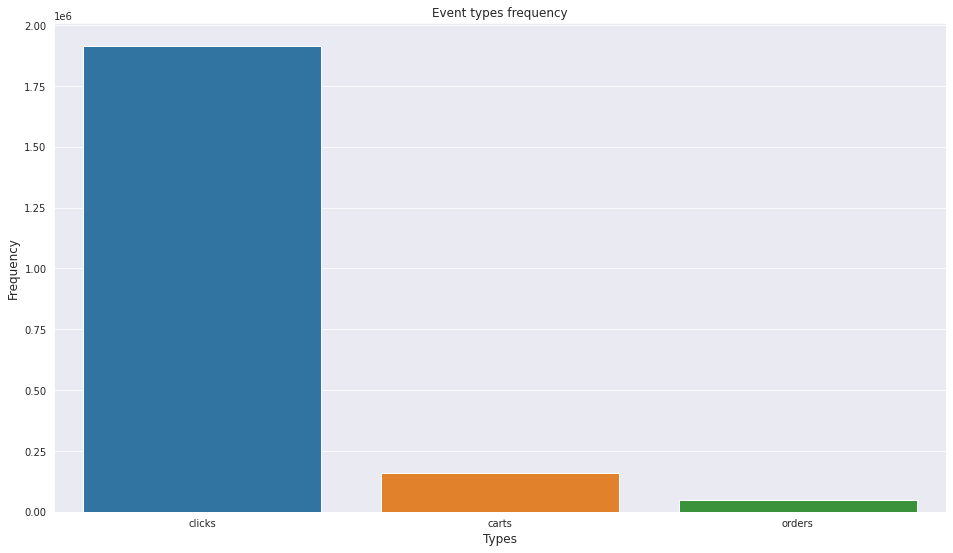

In [12]:
events_types = train_Pdata.groupby(['type'])['type'].count().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(16, 9))
sns.barplot(x=events_types.index, y=events_types.values, ax=ax)
ax.set_title('Event types frequency', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_xlabel('Types', fontsize=12)
plt.show()

Although clicks occurred much more frequently than carts and orders, predicting the latter two events is more important for this competition due to the competition metric.

In [13]:
def count_seconds(x):
    max_value = int(x.max())
    min_value = int(x.min())
    session_time = timedelta(microseconds=max_value - min_value)
    return session_time.total_seconds() / 60 

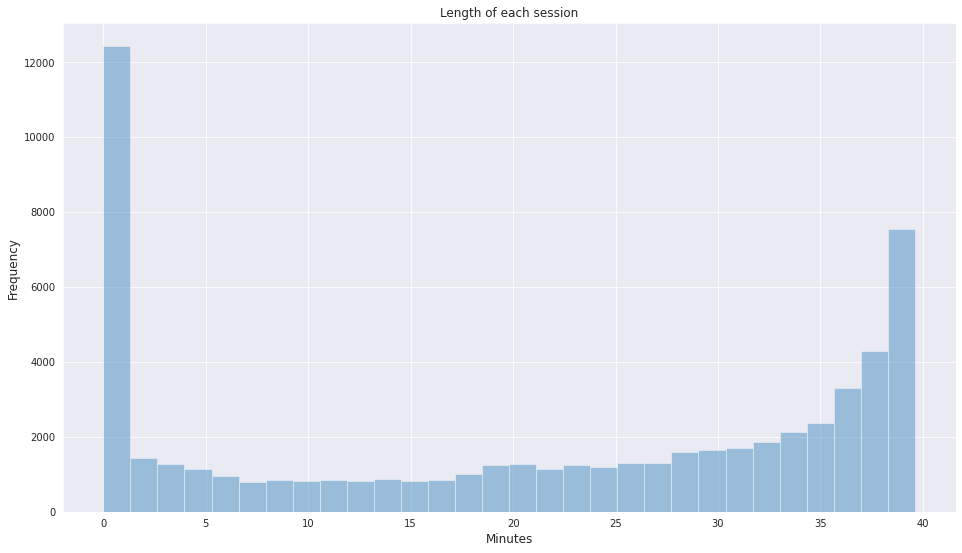

In [14]:
time_counts = train_Pdata.groupby(['session'])['ts'].apply(count_seconds)
fig, ax = plt.subplots(figsize=(16, 9))
sns.distplot(x=time_counts.values, ax=ax, bins=30, kde=False)
ax.set_title('Length of each session', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_xlabel('Minutes', fontsize=12)
plt.show()

4) visualize number of actions, performed in each session

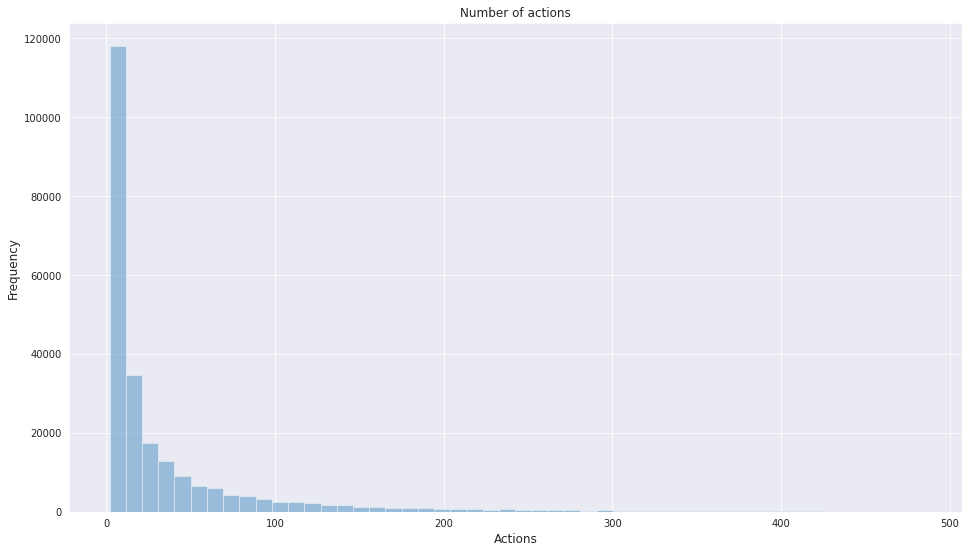

In [15]:
event_types_in_session = train_Pdata.groupby(['session']).count()
fig, ax = plt.subplots(figsize=(16, 9))
sns.distplot(x=event_types_in_session.values, ax=ax, bins=50, kde=False)
ax.set_title('Number of actions', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_xlabel('Actions', fontsize=12)
plt.show()

5) whether users who order something has longer sessions and more events

In [16]:
order_in_session = train_Pdata.groupby(['session']).apply(lambda x: x['type'].eq("orders").any())
order_in_session

session
380000     False
380001     False
380002      True
380003     False
380004      True
           ...  
1139995    False
1139996    False
1139997     True
1139998    False
1139999    False
Length: 60000, dtype: bool

In [17]:
combined_data = pd.concat([event_types_in_session["aid"], time_counts, order_in_session], axis=1)
combined_data

,aid,ts,0
session,,,
380000,14,26.603248,False
380001,2,0.002543,False
380002,69,35.971527,True
380003,4,1.930710,False
380004,32,33.779397,True
...,...,...,...
1139995,13,9.440853,False
1139996,84,10.447219,False
1139997,70,38.818171,True


In [18]:
print(f"Mean time spend by users who order: {combined_data.loc[combined_data[0] == True]['ts'].mean()}")
print(f"Mean time spend by users who didn't order: {combined_data.loc[combined_data[0] == False]['ts'].mean()}")

Mean time spend by users who order: 29.33177746589991
Mean time spend by users who didn't order: 18.761063968265756


In [19]:
print(f"Mean time spend by users who order: {combined_data.loc[combined_data[0] == True]['aid'].mean()}")
print(f"Mean time spend by users who didn't order: {combined_data.loc[combined_data[0] == False]['aid'].mean()}")

Mean time spend by users who order: 89.42287080550746
Mean time spend by users who didn't order: 21.680286603580456


Seems like users who order spend more time and perform more actions

In [20]:
# import pyarrow as pa
# import pyarrow.parquet as pq

# train=pa.Table.from_pandas(train_Pdata)
# pq.write_table(train,'train.parquet')


## Matrix Factorization Algorithm

Matrix factorization is a popular algorithm used in recommender systems to predict user-item interactions. In this algorithm, a user-item matrix is factorized into two lower-dimensional matrices, which are then multiplied together to estimate the missing values. For example, in our case, the user is represented by "aid" and the item is represented by "session".

Number of aid : 218043
Number of session : 51410
   aid  session             ts    type  typeN
0    0        0  1659516383550  clicks      3
1    1        1  1659359236001  clicks      3
2    2        2  1659736393546  clicks      3
3    3        3  1660249249882  clicks      3
4    4        4  1659633425570  clicks      3
(556390, 218043, 51410)
itr range(0, 800)

iteration 50 :
train mse: 39.05820906751178

iteration 100 :
train mse: 30.250935858715426

iteration 150 :
train mse: 23.80808590717721

iteration 200 :
train mse: 18.965659959022123

iteration 250 :
train mse: 15.256156445923818

iteration 300 :
train mse: 12.37506269605948

iteration 350 :
train mse: 10.114998326330435

iteration 400 :
train mse: 8.329897405743562

iteration 450 :
train mse: 6.914085249434321

iteration 500 :
train mse: 5.789399454523154

iteration 550 :
train mse: 4.896935554329122

iteration 600 :
train mse: 4.191581679799381

iteration 650 :
train mse: 3.638300601103833

iteration 700 :
train mse: 3.20

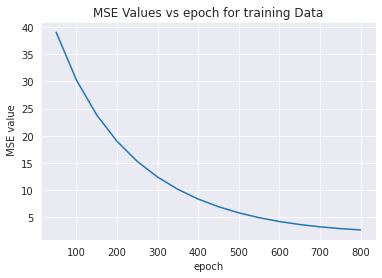

before encoding: (139098, 5)
after encoding: (105636, 5)
Train RMSE : 8.91807555121539 ValidationRMSE: 6.9672519373283075


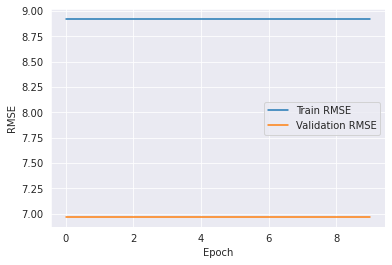

In [27]:
from sklearn.model_selection import train_test_split
from scipy import sparse
train_df, valid_df = train_test_split(train_Pdata, test_size=0.2)
#resetting indices to avoid indexing errors in the future
train_df = train_df.reset_index()[['aid', 'session', 'ts','type','typeN']]
valid_df = valid_df.reset_index()[['aid', 'session','ts','type','typeN']]
# train_df = train_df.drop_duplicates(['aid', 'session'])
def encode_column(column):
#     """ Encodes a pandas column with continous IDs"""
    keys = column.unique()
    key_to_id = {key:idx for idx,key in enumerate(keys)}
    return key_to_id, np.array([key_to_id[x] for x in column]), len(keys)
def encode_df(train_Pdata):
#     """Encodes typeN data with continuous aid and  session"""
    aid, train_Pdata['aid'], num_aid = encode_column(train_Pdata['aid'])
    session, train_Pdata['session'], num_session = encode_column(train_Pdata['session'])
    return train_Pdata, num_aid, num_session, aid, session
train_Pdata, num_aid, num_session, aid, session = encode_df(train_df)
print("Number of aid :", num_aid)
print("Number of session :", num_session)
print(train_Pdata.head())
def create_embeddings(n, K):
#     """
#     Creates a random numpy matrix of shape n, K with uniform values in (0, 11/K)
#     n: number of aid/session
#     K: number of factors in the embedding
#     """
    return 11*np.random.random((n, K)) / K
# train__Pdata, num_aid, num_session, aid, session=encode_df(train_df)
# valid_Pdata, num_aid, num_session, aid, session=encode_df(valid_df)

lmbda = 0.0002
emb_aid = create_embeddings(num_aid, 4)
emb_session = create_embeddings(num_session, 4)

def create_sparse_matrix(df, rows, cols, column_name="typeN"):
  #     """ Returns a sparse utility matrix""" 
#     print("sparse matrix",emb_aid.shape[0],emb_session.shape[0],rows,cols)
    return sparse.csc_matrix((df[column_name].values,(df['aid'].values, df['session'].values)),shape=(rows, cols))
def predict(df, emb_aid, emb_session):
#     """ This function computes df["prediction"] without doing (U*V^T).
    
#     Computes df["prediction"] by using elementwise multiplication of the corresponding embeddings and then 
#     sum to get the prediction u_i*v_j. This avoids creating the dense matrix U*V^T.
#     """
    df['prediction'] = np.sum(np.multiply(emb_aid[df['aid']],emb_session[df['session']]), axis=1)
    return df
def cost(df, emb_aid, emb_session):
#     """ Computes mean square error"""
    Y = create_sparse_matrix(df, emb_aid.shape[0], emb_session.shape[0])
    predicted = create_sparse_matrix(predict(df, emb_aid, emb_session), emb_aid.shape[0], emb_session.shape[0], 'prediction')
    return np.sum((Y-predicted).power(2))/df.shape[0] 
def gradient(df, emb_aid, emb_session):
#     """ Computes the gradient for user and anime embeddings"""
    #print("sparse matrix",emb_aid.shape[0],emb_session.shape[0])
    Y = create_sparse_matrix(df, emb_aid.shape[0], emb_session.shape[0])
    predicted = create_sparse_matrix(predict(df, emb_aid, emb_session), emb_aid.shape[0], emb_session.shape[0], 'prediction')
    delta =(Y-predicted)
    grad_aid = (-2/df.shape[0])*(delta*emb_session) + 2*lmbda*emb_aid
    grad_session = (-2/df.shape[0])*(delta.T*emb_aid) + 2*lmbda*emb_session
    return grad_aid, grad_session
def gradient_descent(df, a, emb_session, iterations=2000, learning_rate=0.01, df_val=None):
    #     """ 
    #     Computes gradient descent with momentum (0.9) for given number of iterations.
    #     emb_aid: the trained aid embedding
    #     emb_session: the trained session embedding
    #     """
    print("itr", range(iterations))
    Y = create_sparse_matrix(df, a.shape[0], emb_session.shape[0])
    beta = 0.91
    grad_aid, grad_session = gradient(df, a, emb_session)
    v_aid = grad_aid
    v_session = grad_session
    itr_array = np.array([])
    tMSE_array = np.array([])
    for i in range(iterations):
        grad_aid, grad_session = gradient(df, a, emb_session)
        v_aid = beta*v_aid + (1-beta)*grad_aid
        v_session = beta*v_session + (1-beta)*grad_session
        a = a - learning_rate*v_aid
        emb_session = emb_session - learning_rate*v_session
        if ( not(i+1)%50):
            print("\niteration", i+1, ":")
            t_mse=cost(df, a, emb_session)
            itr_array = np.append(itr_array, i+1)
            tMSE_array = np.append(tMSE_array, t_mse)
            print("train mse:", t_mse)
            if (df_val is not None):
                print("validation mse:",  cost(df_val, a, emb_session))
    plt.plot(itr_array, tMSE_array)
    plt.xlabel('epoch')
    plt.ylabel(' MSE value')
    plt.title('MSE Values vs epoch for training Data')
    plt.show()
    return emb_aid,emb_session
print((train_Pdata.shape[0], emb_aid.shape[0], emb_session.shape[0]))
emb_aid, emb_session = gradient_descent(train_Pdata, emb_aid, emb_session, iterations=800, learning_rate=1)

#looking at the predictions
valid_df[70:80].head()
def encode_new_data(valid_df, aid, session):
#     """ Encodes valid_df with the same encoding as train_df.
#     """
    df_val_chosen = valid_df['session'].isin(session.keys()) & valid_df['aid'].isin(aid.keys())
    valid_df = valid_df[df_val_chosen]
    valid_df['session'] = np.array([session[x] for x in valid_df['session']])
    valid_df['aid'] = np.array([aid[x] for x in valid_df['aid']])
    return valid_df
print("before encoding:", valid_df.shape)
valid_df = encode_new_data(valid_df, aid, session)
print("after encoding:", valid_df.shape)
valMSE_array = np.array([])
trainMSE_array = np.array([])
for i in range(0,10):
    train_mse = cost(train_df, emb_aid, emb_session)
    val_mse = cost(valid_df, emb_aid, emb_session)
    if(i==0):
        print("Train RMSE :",train_mse,"ValidationRMSE:" ,val_mse)
    valMSE_array = np.append(valMSE_array, val_mse)
    trainMSE_array = np.append(trainMSE_array, train_mse)

# trainMSE_array and valMSE_array are the arrays of train and validation RMSE values, respectively
epochs = range(len(trainMSE_array))
plt.plot(epochs, trainMSE_array, label='Train RMSE')
plt.plot(epochs, valMSE_array, label='Validation RMSE')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.show()

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# create a sample dataframe with recommended items
df =train_Pdata
# group the items by user and sort by score
df = df.sort_values(['aid','session', 'typeN'], ascending=[True, False])
df = df.groupby('typeN').head(100) # limit to top 5 recommendations per user
df1 = df.groupby('aid').head(100) # limit to top 5 recommendations per user
df1 = df.groupby('session').head(100) # limit to top 5 recommendations per user

# create a networkx graph object
G = nx.from_pandas_edgelist(df, 'aid', 'session', ['typeN'])

# set node size based on the number of connections
node_size = [v * 50 for v in dict(G.degree).values()]

# draw the connection chart
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=False, node_size=node_size, font_size=12, alpha=0.8, edge_color='pink')
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'typeN'), font_size=10, alpha=0.8)

plt.show()



In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Sample recommendation data
# recommendations = {
#     'user1': ['item1', 'item2', 'item3'],
#     'user2': ['item1', 'item4'],
#     'user3': ['item2', 'item5'],
#     'user4': ['item4', 'item5', 'item6'],
# }

# Create a graph object
G = nx.Graph()

# Add nodes for each user and item
for typeN, aid in train_Pdata.items():
    G.add_node(typeN, type='typeN')
    for item in aid:
        G.add_node(aid, type='aid')

# Add edges between users and items they are recommended
for typeN, aid in train_Pdata.items():
  
    for item in aid:
        G.add_node(aid, type='aid')
# Define node colors and labels
node_color = {'typeN': 'lightblue', 'aid': 'pink'}
node_labels = {node: node for node in G.nodes()}

# Set node color and label attributes
node_color = [node_color[G.nodes[node]['type']] for node in G.nodes()]
node_labels = {node: node_labels[node] for node in G.nodes()}

# Draw the graph with labels
pos = nx.spring_layout(G, k=0.5)
nx.draw_networkx_nodes(G, pos, node_color=node_color)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10)
plt.axis('off')
plt.show()


In [ ]:
import networkx as nx

# create the connection graph
G = nx.from_pandas_edgelist(train_df, source='aid', target='typeN')

# plot the connection graph
nx.draw(G, with_labels=True)
plt.show()
